# Machine Learning with TensorFlow and SageMaker Debugger

<img src="./img/debugger_overview.png" width="1200" align="center"/>

In [257]:
%pip install pandas==1.1.5
%pip install numpy --upgrade
%pip install jinja2==3.0
%pip install smdebug
%pip install sagemaker --upgrade


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [308]:
import pandas as pd
import glob
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import sagemaker
import os
import boto3
import smdebug
from IPython.core.display import display, HTML
from sagemaker.debugger import Rule, rule_configs, ProfilerConfig, ProfilerRule, FrameworkProfile, DetailedProfilingConfig, DataloaderProfilingConfig, PythonProfilingConfig, PythonProfiler, cProfileTimer, CollectionConfig, DebuggerHookConfig

In [260]:
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()

prefix = 'ipinyou-tf'
os.environ["AWS_REGION"] = region

print(f'Region:  {region}')
print(f'IAM Role:  {role}')
print(f'S3 Bucket:  {bucket_name}')

# Get the current installed version of Sagemaker SDK, TensorFlow, Python, Boto3 and SMDebug
print(f'SageMaker Python SDK version:  {sagemaker.__version__}')
#print(f'TensorFlow version : {tf.__version__}')
print(f'Python version:  {sys.version}')
print(f'Boto3 version : {boto3.__version__}')
print(f'SMDebug version:  {smdebug.__version__}')
print(f'Pandas Version:  {pd.__version__}')

Region:  us-east-1
IAM Role:  arn:aws:iam::431615879134:role/sagemaker-test-role
S3 Bucket:  sagemaker-us-east-1-431615879134
SageMaker Python SDK version:  2.103.0
Python version:  3.7.10 (default, Jun  4 2021, 14:48:32) 
[GCC 7.5.0]
Boto3 version : 1.24.12
SMDebug version:  1.0.12
Pandas Version:  1.1.5


LAST TESTED VERSIONS:

```
SageMaker Python SDK version : 2.103.0
TensorFlow version : 2.3.1
Python version : 3.7.10
Boto3 version : 1.24.12
SMDebug version : 1.0.12
Pandas version : 1.1.5
```

## SageMaker Debugger

Rules - configure debugger built-in rules that you want to run in parallel. These rules look for common training issues. The ProfilerReport saves the debugging profiling reports into your S3 bucket.  For a full list of debugger rules see - https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html

<img src="./img/debugger_new_arch.png" width="1000" align="center"/>

In [261]:
rules=[
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(
        base_config=rule_configs.stalled_training_rule(),
        rule_parameters={
                "threshold": "1800",
                "stop_training_on_fire": "True",
                "training_job_name_prefix": "tensorflow231-g4-ipenyou-gpu-inmem-csv"
        },
        collections_to_save=[ 
            CollectionConfig(
                name="losses", 
                parameters={
                    "save_interval": "500"
                } 
            )
        ]
    )
]

### What tensors do you want to collect?

Below are the built in collections we are going to track.  By default, debugger will capture tensors at every 500 steps.  Note that we can also specify a regular expression to collect custom tensors. To see the full list of built in collections - https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#built-in-collections 

In [262]:
debugger_hook_config = DebuggerHookConfig(
    hook_parameters={"save_interval":"2000"}, # steps
    collection_configs=[
        CollectionConfig(name="inputs"),
        CollectionConfig(name="outputs"),
        CollectionConfig(name="layers"),
        CollectionConfig(name="gradients")
    ])

### Configure the profiler

To capture performance data configure the profiler
* System Metrics - CPU and GPU utilization, memory, network, I/O
* Framework Metrics - Dataloading, preprocessing, GPU operators
* Python profiling - Most expensive functions in your script

You specify the interval in milliseconds and each configuration can be customized on where to start profiling and where to stop.  Note that time based profiling is also an option.  

In [264]:
# profiler and debugger
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile()
)

# Training

With the following profiler_config parameter configuration, Debugger calls the default settings of monitoring, collecting system metrics every 500 milliseconds. 

## CSV Data

In [228]:
sagemaker_session.upload_data('train.csv',bucket=bucket_name,key_prefix=f'{prefix}/data/train')
sagemaker_session.upload_data('test.csv',bucket=bucket_name,key_prefix=f'{prefix}/data/test')

's3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/test/test.csv'

### Data in Memory

In [265]:
training_job_name = "tf231-g4-ipinyou-inmem-csv"

In [266]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/data/train', content_type='csv', distribution='ShardedByS3Key')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/data/test', content_type='csv', distribution='ShardedByS3Key')

In [267]:
hyperparameters = {'epochs': 5,
                   'batchsize': 2048,
                   'lr': 4e-3,
                  }

In [268]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name=training_job_name,
    source_dir="code",
    entry_point="tf_profile_fit_csv_inmem.py",
    role=role,
    py_version="py37",
    framework_version="2.3.1",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    sagemaker_session=sagemaker_session,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    hyperparameters=hyperparameters
)


In [382]:
estimator.latest_training_job.job_name

'tf231-g4-ipinyou-parquet-2022-08-12-21-28-42-084'

In [269]:
estimator.fit({'train': s3_input_train, 'validation': s3_input_test})

2022-08-12 16:30:22 Starting - Starting the training job...
2022-08-12 16:30:40 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
StalledTrainingRule: InProgress
ProfilerReport: InProgress
.........
2022-08-12 16:32:16 Downloading - Downloading input data
2022-08-12 16:32:16 Training - Downloading the training image..............2022-08-12 16:34:30.470731: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-08-12 16:34:30.479390: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 1
2022-08-12 16:34:30.480669: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:121] SageMaker Profiler Timeline Writer read the following config parameters :
2022-08-12 16:34:30.480691: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:122] Base Folder : /opt/ml/output/profiler
2022-08-12 16:34:30.

### Debugger Results

In [371]:
from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram
from smdebug.profiler.analysis.notebook_utils.step_timeline_chart import StepTimelineChart
from smdebug.profiler.analysis.notebook_utils.step_histogram import StepHistogram
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug.profiler.analysis.notebook_utils.heatmap import Heatmap
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
import time

### Interactive Analysis

In [319]:
# This assumes that the job was trained in the same AWS region as the S3 bucket where the debugger output is stored
# If not, then make appropriate changes to the following code
tj = TrainingJob(estimator.latest_training_job.job_name, region)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-431615879134/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 7, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 5, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 13, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 9, "NumSteps": 3, "ProfilerName": "cprofile", "cProfileTimer": "default", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 15, "NumSteps": 1, }'}}
s3 path:s3://sagemaker-us-east-1-431615879134/tf231-g4-ipinyou-inmem-csv-2022-08-12-16-30-22-295/profiler-output


#### Read the metrics
1. Wait for the the system and framework metrics to be available.
1. Get the reader objects for both of these metrics.
1. Refresh the event file lists that contains these metrics.

In [320]:
# Wait for the data to be available
tj.wait_for_sys_profiling_data_to_be_available()
tj.wait_for_framework_profiling_data_to_be_available()
# Get the metrics reader
system_metrics_reader = tj.get_systems_metrics_reader()
framework_metrics_reader = tj.get_framework_metrics_reader()
# Refresh the event file list
system_metrics_reader.refresh_event_file_list()
framework_metrics_reader.refresh_event_file_list()



Profiler data from system is available
[2022-08-12 17:38:56.623 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:9601 INFO algorithm_metrics_reader.py:192] S3AlgorithmMetricsReader created with bucket:sagemaker-us-east-1-431615879134 and prefix:tf231-g4-ipinyou-inmem-csv-2022-08-12-16-30-22-295/profiler-output/framework/


 Profiler data from framework is available
Found recorded framework annotations. Latest available timestamp microsseconds_since_epoch is:1660322171781373 , human_readable_timestamp in utc: 2022-08-12T16:36:11:781373


#### Plots

In [323]:
# system metrics
metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["CPU", "GPU", "I/O"],
    select_events=["total"]
)

Found 8591 system metrics events from timestamp_in_us:0 to timestamp_in_us:1660322160000000
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [325]:
# Steps Chart
view_step_timeline_chart = StepTimelineChart(framework_metrics_reader)

[2022-08-12 17:41:59.948 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:9601 INFO metrics_reader_base.py:134] Getting 4 event files
[2022-08-12 17:42:00.242 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:9601 INFO algorithm_metrics_reader.py:233] Invalid tracefilename:s3://sagemaker-us-east-1-431615879134/tf231-g4-ipinyou-inmem-csv-2022-08-12-16-30-22-295/profiler-output/framework/tensorflow/detailed_profiling/2022081216/000000005/plugins/profile/2022_08_12_16_35_13/ip-10-2-67-120.ec2.internal.memory_profile.json.gz . Skipping.
Reading event from tracefile:s3://sagemaker-us-east-1-431615879134/tf231-g4-ipinyou-inmem-csv-2022-08-12-16-30-22-295/profiler-output/framework/tensorflow/detailed_profiling/2022081216/000000005/plugins/profile/2022_08_12_16_35_13/ip-10-2-67-120.ec2.internal.trace.json.gz and node_id:ip-10-2-67-120
Reading event from tracefile:s3://sagemaker-us-east-1-431615879134/tf231-g4-ipinyou-inmem-csv-2022-08-12-16-30-22-295/profiler-output/framewor

In [326]:
step_histogram = StepHistogram(framework_metrics_reader)
step_histogram.plot(
    starttime=step_histogram.last_timestamp - 5 * 1000 * 1000, 
    endtime=step_histogram.last_timestamp, 
    show_workers=True
)

StepHistogram created, last_timestamp found:1660322171781373
stephistogram getting events from 1660322166781373 to 1660322171781373
[2022-08-12 17:42:50.684 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:9601 INFO metrics_reader_base.py:134] Getting 3 event files
Reading event from tracefile:s3://sagemaker-us-east-1-431615879134/tf231-g4-ipinyou-inmem-csv-2022-08-12-16-30-22-295/profiler-output/framework/tensorflow/detailed_profiling/2022081216/000000005/plugins/profile/2022_08_12_16_35_13/ip-10-2-67-120.ec2.internal.trace.json.gz and node_id:ip-10-2-67-120
Total events fetched:1022
Select metrics:['Step:ModeKeys', 'Forward-node', 'Backward\\(post-forward\\)-node']
Available_metrics: ['Step:ModeKeys.EVAL-nodeid:algo-1-26']
Filtered metrics:['Step:ModeKeys.EVAL-nodeid:algo-1-26']


In [332]:
view_timeline_charts = TimelineCharts(
    system_metrics_reader, 
    framework_metrics_reader,
    select_dimensions=["CPU", "GPU", "I/O"],
    select_events=["total"] 
)

select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [340]:
view_heatmap = Heatmap(
    system_metrics_reader,
    framework_metrics_reader,
    select_dimensions=[".*CPU", ".*GPU"],
    select_events=[".*"],
    plot_height=450, 
    show_workers=True
)

select events:['.*']
select dimensions:['.*CPU', '.*GPU']
filtered_events:{'gpu0', 'total', 'cpu3', 'MemoryUsedPercent', 'cpu1', 'TransmitBytesPerSecond', 'ReadThroughputInBytesPerSecond', 'cpu2', 'cpu0', 'IOPS', 'WriteThroughputInBytesPerSecond', 'ReceiveBytesPerSecond'}
filtered_dimensions:{'CPUUtilization', 'GPUMemoryUtilization', 'GPUUtilization'}


## SageMaker Debugger Trials

In [341]:
estimator.latest_job_debugger_artifacts_path()

's3://sagemaker-us-east-1-431615879134/tf231-g4-ipinyou-inmem-csv-2022-08-12-16-30-22-295/debug-output'

In [342]:
from smdebug.trials import create_trial

path = estimator.latest_job_debugger_artifacts_path()
print(f'Tensors are stored in {path}')

trial = create_trial(path)

Tensors are stored in s3://sagemaker-us-east-1-431615879134/tf231-g4-ipinyou-inmem-csv-2022-08-12-16-30-22-295/debug-output
[2022-08-12 18:03:03.624 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:9601 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-431615879134/tf231-g4-ipinyou-inmem-csv-2022-08-12-16-30-22-295/debug-output


In [343]:
trial.tensor_names()

['accuracy',
 'batch',
 'dense/inputs',
 'dense/outputs',
 'dense_1/inputs',
 'dense_1/outputs',
 'dense_2/inputs',
 'dense_2/outputs',
 'dense_3/inputs',
 'dense_3/outputs',
 'dropout/inputs',
 'dropout/outputs',
 'dropout_1/inputs',
 'dropout_1/outputs',
 'gradients/dense/biasGrad',
 'gradients/dense/kernelGrad',
 'gradients/dense_1/biasGrad',
 'gradients/dense_1/kernelGrad',
 'gradients/dense_2/biasGrad',
 'gradients/dense_2/kernelGrad',
 'gradients/dense_3/biasGrad',
 'gradients/dense_3/kernelGrad',
 'inputs',
 'labels',
 'loss',
 'predictions',
 'val_accuracy',
 'val_loss']

In [344]:
trial.collections()

{'weights': <class Collection: name=weights>,
 'metrics': <class Collection: name=metrics>,
 'biases': <class Collection: name=biases>,
 'all': <class Collection: name=all>,
 'layers': <class Collection: name=layers>,
 'sm_metrics': <class Collection: name=sm_metrics>,
 'gradients': <class Collection: name=gradients>,
 'default': <class Collection: name=default>,
 'outputs': <class Collection: name=outputs>,
 'inputs': <class Collection: name=inputs>,
 'losses': <class Collection: name=losses>,
 'optimizer_variables': <class Collection: name=optimizer_variables>}

In [385]:
trial.tensor_names(collection='default')

[2022-08-15 13:51:49.107 datascience-1-0-ml-m5-2xlarge-edc54522b6c2075d0551eb4e13d2:9601 WARNING trial.py:427] No tensors from the collection default were saved


[]

In [346]:
import matplotlib.pyplot as plt

In [347]:
def get_data(trail, tname):
    tensor = trail.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

In [348]:
steps, vals = get_data(trial, 'loss')
steps2,vals2 = get_data(trial, 'val_loss')

f,a = plt.subplots(figsize=(10,5))
a.plot(steps,vals, label='train loss')
a.plot(steps2,vals2, label='val loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.ylim((0,0.5))
plt.legend()

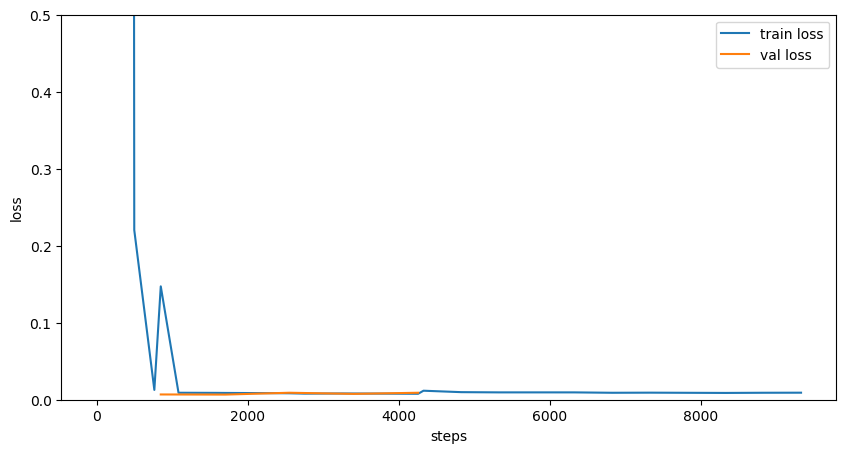

In [349]:
plt.show()

## Rules

In [350]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:431615879134:processing-job/tf231-g4-ipinyou-inmem-csv-lossnotdecreasing-ca39ec0e',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2022, 8, 12, 16, 40, 58, 223000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:431615879134:processing-job/tf231-g4-ipinyou-inmem-csv-overfit-7463b1d2',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2022, 8, 12, 16, 40, 58, 223000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtraining',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:431615879134:processing-job/tf231-g4-ipinyou-inmem-csv-overtraining-bfd51e4f',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2022, 8, 12, 16, 40, 58, 223000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'StalledTrainingRule',
  'RuleEval

### Profile Report

In [372]:
# Get the S3 path to the debugger's auto-generated profiling report
profiler_output_path = estimator.latest_job_profiler_artifacts_path()
profiling_report = f"{'/'.join(profiler_output_path.split('/')[:-1])}/rule-output/ProfilerReport/profiler-output/profiler-report.html"
!aws s3 cp {profiling_report} .

download: s3://sagemaker-us-east-1-431615879134/tf231-g4-ipinyou-parquet-2022-08-12-19-47-03-364/rule-output/ProfilerReport/profiler-output/profiler-report.html to ./profiler-report.html


## Training with CSV using tf.data

In [351]:
training_job_name = "tf231-g4-ipinyou-tfdata-csv"

In [352]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/data/train', content_type='csv', distribution='ShardedByS3Key')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/data/test', content_type='csv', distribution='ShardedByS3Key')

In [353]:
hyperparameters = {'epochs': 5,
                   'batchsize': 2048,
                   'lr': 4e-3,
                  }

In [354]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name=training_job_name,
    source_dir="code",
    entry_point="tf_profile_fit_csv.py",
    role=role,
    py_version="py37",
    framework_version="2.3.1",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    sagemaker_session=sagemaker_session,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    hyperparameters=hyperparameters
)


In [355]:
estimator.fit({'train': s3_input_train, 'validation': s3_input_test})

2022-08-12 18:24:56 Starting - Starting the training job...
2022-08-12 18:25:20 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overfit: InProgress
Overtraining: InProgress
StalledTrainingRule: InProgress
ProfilerReport: InProgress
.........
2022-08-12 18:26:51 Downloading - Downloading input data
2022-08-12 18:26:51 Training - Downloading the training image..............2022-08-12 18:29:06.018700: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-08-12 18:29:06.023429: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 1
2022-08-12 18:29:06.024438: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:121] SageMaker Profiler Timeline Writer read the following config parameters :
2022-08-12 18:29:06.024468: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:122] Base Folder : /opt/ml/output/profiler
2022-08-12 18:29:06.

## TF Record Training

In [356]:
!aws s3 cp ./data/tfrecords/test/ s3://{bucket_name}/{prefix}/data/test_tfr/ --recursive

upload: data/tfrecords/test/test_0-3.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/test_tfr/test_0-3.tfrec
upload: data/tfrecords/test/test_1-3.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/test_tfr/test_1-3.tfrec
upload: data/tfrecords/test/test_2-3.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/test_tfr/test_2-3.tfrec


In [357]:
!aws s3 cp ./data/tfrecords/train/ s3://{bucket_name}/{prefix}/data/train_tfr/ --recursive

upload: data/tfrecords/train/train_12-30.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/train_tfr/train_12-30.tfrec
upload: data/tfrecords/train/train_0-30.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/train_tfr/train_0-30.tfrec
upload: data/tfrecords/train/train_11-30.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/train_tfr/train_11-30.tfrec
upload: data/tfrecords/train/train_10-30.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/train_tfr/train_10-30.tfrec
upload: data/tfrecords/train/train_1-30.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/train_tfr/train_1-30.tfrec
upload: data/tfrecords/train/train_14-30.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/train_tfr/train_14-30.tfrec
upload: data/tfrecords/train/train_15-30.tfrec to s3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/train_tfr/train_15-30.tfrec
upload: data/tfrecords/train/train_17-30.tfrec to s3://sagemaker-us-east-1-43161

In [351]:
training_job_name = "tf231-g4-ipinyou-tfdata-csv"

In [358]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/data/train_tfr', distribution='ShardedByS3Key')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/data/test_tfr', distribution='ShardedByS3Key')

In [359]:
hyperparameters = {'epochs': 5,
                   'batchsize': 2048,
                   'lr': 4e-3,
                  }

In [369]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name=training_job_name,
    source_dir="code",
    entry_point="tf_profile_fit_tfrecord.py",
    role=role,
    py_version="py37",
    framework_version="2.3.1",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    sagemaker_session=sagemaker_session,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    hyperparameters=hyperparameters
)

In [ ]:
estimator.fit({'train': s3_input_train, 'validation': s3_input_test})

# Parquet Record Training

In [373]:
training_job_name = "tf231-g4-ipinyou-parquet"

In [374]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=f's3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/parquet_train/', distribution='ShardedByS3Key')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data=f's3://sagemaker-us-east-1-431615879134/ipinyou-tf/data/parquet_test/', distribution='ShardedByS3Key')

In [375]:
hyperparameters = {'epochs': 5,
                   'batchsize': 2048,
                   'lr': 4e-3,
                  }

In [376]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name=training_job_name,
    source_dir="code",
    entry_point="tf_profile_fit_parquet.py",
    role=role,
    py_version="py37",
    framework_version="2.3.1",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    sagemaker_session=sagemaker_session,
    profiler_config=profiler_config,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    hyperparameters=hyperparameters
)

In [ ]:
estimator.fit({'train': s3_input_train, 'validation': s3_input_test})

* https://github.com/aws-samples/sagemaker-end-to-end-distributed-tensorflow2
* https://github.com/aws-samples/amazon-sagemaker-script-mode/blob/master/tf-distribution-options/tf-distributed-training.ipynb